<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>Single Star Lightcurve with the Butler</b> <br>
Last verified to run on 2021-07-28 with LSST Science Pipelines release w_2021_25 <br>
Contact authors: Melissa Graham, Jeff Carlin <br>
Target audience: All DP0 delegates. <br>
Container Size: medium <br>
Questions welcome at <a href="https://community.lsst.org/c/support/dp0">community.lsst.org/c/support/dp0</a>. <br>
Find DP0 documentation and resources at <a href="https://dp0-1.lsst.io">dp0-1.lsst.io</a>. <br>

**Credit:** This tutorial notebook was created by Jeff Carlin, Leanne Guy, and Melissa Graham, and draws on material in the fourth notebook "04 Intro to Butler".

### Caveats

The DP0.1 data set is not well suited to large-scale time domain analyses, and one goal of this notebook is to clearly illustrate the limitations.

The DP0.1 data set does not contain any data products from difference image analysis.

A catalog of sources detected in processed visit images (PVIs) is available via the Butler (read more in the [DP0.1 DPDD](https://dp0-1.lsst.io/data-products-dp0-1/index.html#dp0-1-data-products-definition-document-dpdd)).
However, this source catalog does not include *associations* of PVI sources by sky coordinate, nor associations between PVI sources and objects detected in the deep coadded images.

It is recommended that DP0 delegates work through the Butler notebooks "01 Intro to DP0 Notebooks" and "04 Intro to Butler" before using this notebook.

### Learning Objectives

First, use the TAP Service to find a time-domain target to make a light curve for.

Then, use the Butler to retrieve all detected sources from all processed visit images (PVIs or `calexps`) at a given sky coordinate, and plot magnitude as a function of time.

In [1]:
%load_ext pycodestyle_magic
%flake8_on

### Set Up

Import the packages we will need for this notebook.

In [4]:
### Rubin-specific packages

import lsst.daf.butler as dafButler
import lsst.geom as geom
import lsst.sphgeom as sphgeom
import lsst.daf.base as dafBase

# from rubin_jupyter_utils.lab.notebook import get_tap_service
# service = get_tap_service()

### General python / astronomy packages

import matplotlib.pyplot as plt
import numpy as np

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits
from astropy.timeseries import LombScargle

import time

Create an instance of the Butler.

In [29]:
repo = 's3://butler-us-central1-dp01'
collection = "2.2i/runs/DP0.1"
butler = dafButler.Butler(repo, collections=collection)
registry = butler.registry

### 1. Use the TAP Service to choose a variable star.

Retrieve the RA and Dec of elements in the `truth_match` table that are within a 1 degree radius circle near the center of the DC2 region, and have `is_variable = 1` (is variable), `truth_type = 2` (is a star), and `mag_r > 20` (r-band AB magnitude is brighter than 20).
Find more information about the `truth_match` table in the [DP0.1 DPDD](https://dp0-1.lsst.io/data-products-dp0-1/index.html#dp0-1-data-products-definition-document-dpdd).

In [30]:
# results = service.search("SELECT ra, dec "\
#                          "FROM dp01_dc2_catalogs.truth_match "\
#                          "WHERE CONTAINS(POINT('ICRS', ra, dec), "\
#                          "CIRCLE('ICRS', 62.0, -37.0, 1.0)) = 1 "\
#                          "AND is_variable = 1 AND truth_type = 2 AND mag_r > 20 ",\
#                          maxrec=10000)

5:80: E501 line too long (85 > 79 characters)


Alternatively, you might want to choose a Type Ia supernova, but note that Section 5 of this notebook assumes you've retrieved data for a variable star.

To use the TAP service to find Type Ia supernovae, set: truth_type = 3

In [31]:
# results = service.search("SELECT ra, dec, host_galaxy "\
#                          "FROM dp01_dc2_catalogs.truth_match "\
#                          "WHERE CONTAINS(POINT('ICRS', ra, dec), "\
#                          "CIRCLE('ICRS', 62.0, -37.0, 1.0)) = 1 "\
#                          "AND truth_type = 3 ", maxrec=10000)

Convert the results to a pandas data frame and show it.

In [32]:
# data = results.to_table().to_pandas()
# data

Clean up, we don't need these anymore.

In [33]:
# del results,data
# del service

### 2. Execute spatial search of the `src` catalogs with the Butler.

For now, we will select a star that is known to be a simulated RR Lyrae variable. The star of interest is located at a position (RA, Dec) = (60.2837946, -35.4042439) degrees. 

Use [astropy.SkyCoord](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html) to define a coordinate object for this variable star.

In [34]:
targ_coord = SkyCoord(ra=60.2837946 * u.deg, dec=-35.4042439 * u.deg)

Use these coordinates to define the HTM ID spatial search region to pass to the Butler's `queryDatasets` function.

Find more details about sky pixelization with HTM, and Butler spatial queries and the `dataId`, in Section 2.5 of notebook "04 Intro to Butler".

In [35]:
pixelization = sphgeom.HtmPixelization(15)
htm_id = pixelization.index(sphgeom.UnitVector3d(sphgeom.LonLat.fromDegrees(
                            targ_coord.ra.value, targ_coord.dec.value)))

# Obtain and print the scale to provide a sense of the size of the
#   sky pixelization being used
scale = pixelization.triangle(htm_id).getBoundingCircle().getOpeningAngle().asDegrees() * 3600
print(f'HTM ID={htm_id} at level={pixelization.getLevel()} is a ~{scale:0.2}" triangle.')

7:80: E501 line too long (94 > 79 characters)
8:80: E501 line too long (89 > 79 characters)


HTM ID=9418649859 at level=15 is a ~8.4" triangle.


<br>

Now we will query the `src` datasets (i.e., measurements from each processed visit image) for this HTM pixel via the Butler. Notice that the ID for the HTM triangle of interest was extracted using the RA, Dec coordinates of the star of interest. When we extract dataset references, we can limit it to return only catalogs overlapping that HTM "pixel."

To keep things simple, we will just query for r-band data.

Find more details about the `src` catalog in the [DP0.1 DPDD](https://dp0-1.lsst.io/data-products-dp0-1/index.html#dp0-1-data-products-definition-document-dpdd).

In [36]:
datasetRefs = registry.queryDatasets("src", htm20=htm_id,
                                     collections=collection,
                                     where="band in ('r')")

In [37]:
datasetRefs

Extract the datasetRefs into a python list called `refs` to speed up access to the dataIds in Section 3. This may take a little while (~30 seconds).

In [38]:
refs = list(datasetRefs)
totalNrefs = len(refs)

print(totalNrefs, ' catalogs matching the requested position.')

108  catalogs matching the requested position.


<br>

Let's take a look at a `dataId` from the list we have compiled. It should specify the `visit` and `detector` containing the star, and the `band` (r) that we specified in the query.

In [39]:
refs[0].dataId.full

{band: 'r', instrument: 'LSSTCam-imSim', detector: 58, physical_filter: 'r_sim_1.4', visit_system: 1, visit: 1006041}

### 3. Loop over search results and store `src` data in python lists.

The DP0.1 work-around for building a light curve is as follows.

**WARNING:** This is *not representative* of how LSST light curves will be built and accessed by users. This is a *temporary work-around* for DP0.1.

 1. For each query result (i.e., each element of `refs`), use the `dataId` to retrieve all sources for that query result.
 2. Calculate the separation of each source from the target.
 3. If the nearest source is within 1.5" of the target, assume it _is_ the target.
 4. Append the following quantities for the nearest source into a python list:
   * -- RA and Dec
   * -- separation (between the supplied position and the measured position in each visit image)
   * -- r-band magnitude
   * -- visit and detector IDs
   * -- date of observation (as a "Modified Julian Date," or MJD)

**The above process can take ~30 minutes: choose option A to do it anyway, and option B to skip to plotting a pre-made lightcurve.**

**Option A: retrieve source photometry via the Butler:** <br>
Uncomment and execute the following two cells, which perform the steps listed above.  <br>
**WARNING**: this takes a _long_ time, sometimes up to 30 minutes, to run. <br>
**WARNING:** If you choose option A, scroll down and comment-out the cell for option B.

**Option B (RECOMMENDED): read the previously-generated data file (this is the default option for this notebook):** <br>
Scroll down and execute the cell under OPTION B. 
It will read in a FITS file containing the results previously created by OPTION A.

#### 3.1 OPTION A: Retrive source photometry via the Butler (can take ~30 minutes)

Uncomment the following two cells and execute them in order to build the light curve yourself.

In [52]:
# t0 = time.time()
# print(t0)

# # To retrieve data for all `refs`, set N_refs to be equal to totalNrefs (or to a large value like 1000).
# # Alternatively to test the retrieval of a few `refs`, set smaller (e.g., 10).
# # Nrefs = totalNrefs
# Nrefs = 5

# # Instantiate empty lists
# ra_arr = []
# dec_arr = []
# sep_arr = []
# mag_arr = []
# visit_arr = []
# detector_arr = []
# mjd_arr = []

# # Loop over all refs
# for i, d in enumerate(refs):
#     t1 = time.time()

#     if i <= Nrefs:

#         # Use the butler to get all sources for this datasetRef's dataId
#         did = d.dataId
#         src = butler.get('src', dataId=did)

#         # Get the separation of all sources from the target
#         src_coords = SkyCoord(ra=src['coord_ra'] * u.rad,
#                               dec=src['coord_dec'] * u.rad)
#         sep = src_coords.separation(targ_coord)

#         # If the nearest source is within 1.5", append source quantities to python lists
#         if np.min(sep.arcsecond) < 1.5:
#             sx = np.argmin(sep.arcsecond)

#             # Append RA, Dec, and separation
#             ra_arr.append(src['coord_ra'][sx])
#             dec_arr.append(src['coord_dec'][sx])
#             sep_arr.append(sep[sx].arcsecond)

#             # Append r-band magnitude (AB mag from the calibrated flux in nJy).
#             # The calibrated flux in nJy is base_PsfFlux_instFlux times base_localPhotoCalib
#             mag_arr.append(-2.5 * np.log10(src['base_PsfFlux_instFlux'][sx] * src['base_localPhotoCalib'][sx]) + 31.4)

#             # Append visit and detector information
#             visit_arr.append(did['visit'])
#             detector_arr.append(did['detector'])

#             # Append MJD (from this src's associated image's header)
#             visit_info = butler.get('calexp.visitInfo', dataId=did)
#             mjd_arr.append(visit_info.getDate().get(dafBase.DateTime.MJD))

#             del sx

#         t2 = time.time()
#         if i == 0:
#             print('Each data point takes: ', t2 - t1, ' seconds to retrieve.')
#             print('Retrieving ', Nrefs, ' data points will take ',
#                   (t2 - t1) * Nrefs / 60.0, ' minutes.')

#         del did, src, src_coords, sep
#         del t1, t2

# print('Total run-time was: ', (time.time() - t0) / 60.0, ' minutes.')
# del t0

4:80: E501 line too long (106 > 79 characters)
5:80: E501 line too long (80 > 79 characters)
33:80: E501 line too long (90 > 79 characters)
42:80: E501 line too long (81 > 79 characters)
43:80: E501 line too long (94 > 79 characters)
44:80: E501 line too long (120 > 79 characters)
58:80: E501 line too long (80 > 79 characters)


<blockquote>
As a side-note, there are options for how the Butler can be used to get the photometric calibration and visit info for a source.
One alternative is to retrieve the full `calexp` to get the `photCalib` and `visitInfo`.

Retrieve the `calexp`:<br>
``calexp = butler.get('calexp', dataId=did, collections=collection)``

Apply the `calexp`'s photometric calibration to the flux:<br>
``calib = calexp.getPhotoCalib()``<br>
``mag_arr.append(calib.instFluxToMagnitude(src['base_PsfFlux_instFlux'][sx]))``

Convert the `calexp`'s header date to MJD:<br>
``date_obs = calexp.getInfo().getVisitInfo().getDate()``<br>
``mjd_arr.append(date_obs.get(dafBase.DateTime.MJD))``

In general, the Butler is very flexible software and there are often multiple ways to achieve the same goal.
</blockquote>

Make an AstroPy Table of the data.

In [51]:
# tab_timeseries = Table([mjd_arr, ra_arr, dec_arr, sep_arr, mag_arr,
#                         visit_arr, detector_arr],
#                        names=['mjd', 'ra', 'dec', 'separation', 'mag',
#                               'visit', 'detector'])

Save the timeseries data to a FITS file for later use.

**WARNING:** This will overwrite the provided file "timeseries_rband.fits" unless you rename it.

In [53]:
# tab_timeseries.write('timeseries_rband.fits', overwrite=True)

#### 3.2 OPTION B: Read the previously-generated data file. 

**WARNING:** Comment this out if you chose to do option A.

In [54]:
tab_timeseries = fits.getdata('timeseries_rband.fits')

#### 3.3 After option A OR option B:
Confirm that the expected columns are in the table.

In [55]:
tab_timeseries.columns

ColDefs(
    name = 'mjd'; format = 'D'
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'separation'; format = 'D'
    name = 'mag'; format = 'D'
    name = 'visit'; format = 'K'
    name = 'detector'; format = 'K'
)

### 4. Plot a time series (magnitude vs. time) of the star's measurements:

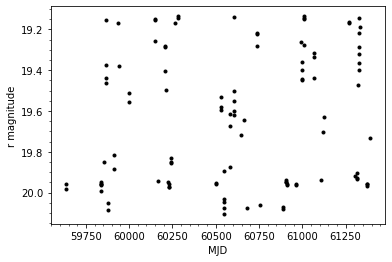

In [56]:
plt.plot(tab_timeseries['mjd'], tab_timeseries['mag'], 'k.')
plt.xlabel('MJD')
plt.ylabel('r magnitude')
plt.gca().invert_yaxis()
plt.minorticks_on()
plt.show()

Hooray! The star is clearly a variable, with a peak-to-peak variation of almost a full magnitude. We have successfully extracted a time series of a variable star!

In [58]:
# What timespan do these measurements cover?
time_days = np.max(tab_timeseries['mjd']) - np.min(tab_timeseries['mjd'])
time_years = time_days / 365.25
print('Time span in days: ', time_days, '; Time in years: ', time_years)

Time span in days:  1758.1289079988346 ; Time in years:  4.813494614644311


### 5. Bonus: find the star's period and make a phase-folded light curve

In the above plot, it's clear that the star is variable, but with ~100 measurements spread over ~1750 days (almost 5 years), its period is unclear. To extract a period from this time series, we will need to construct a _periodogram_, identify the most likely period, then "fold" the lightcurve by placing each measurement at the appropriate phase (i.e., between the start of the variability phase at 0.0 and the end of the cycle at 1.0).

_Major caveat: the CET members who created this notebook are not variable star experts, so the method shown here is definitely not the "best", state-of-the-art way of doing this. Contributions that improve on this are welcome from delegates!_

We will use a "Lomb-Scargle Periodogram," which is a statistical method for extracting periodicity from time series data. In particular, we'll use the [Astropy Lomb-Scargle](https://docs.astropy.org/en/stable/timeseries/lombscargle.html) implementation.

In [62]:
# Make arrays with units attached:

mjd_days = np.array(tab_timeseries['mjd']) * u.day
mags = np.array(tab_timeseries['mag']) * u.mag

# The Lomb-Scargle periodogram returns the power at different frequencies.

# Because we know this is an RR Lyrae star, its period must be between
# ~0.2-0.9 days. We will use the min/max frequency settings to limit our
# period search to 0.05-1.25 days.

min_freq_search = 1.0 / (1.25 * u.day)
max_freq_search = 1.0 / (0.05 * u.day)

# frequency, power = LombScargle(mjd_days, mags).autopower()
frequency, power = LombScargle(mjd_days, mags).autopower(minimum_frequency=min_freq_search,
                                                         maximum_frequency=max_freq_search)

16:80: E501 line too long (91 > 79 characters)
17:80: E501 line too long (91 > 79 characters)


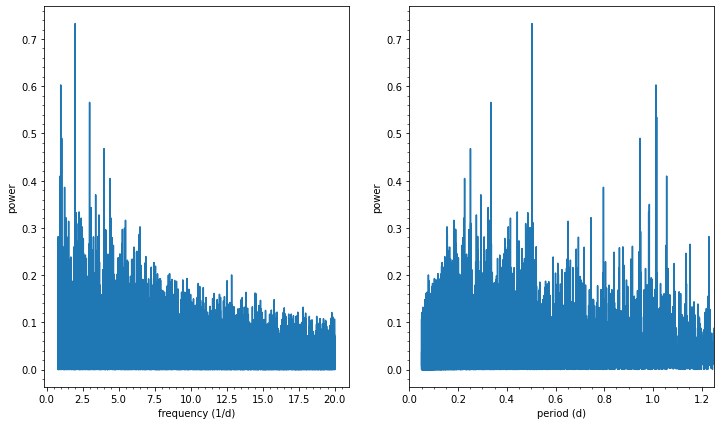

In [64]:
# Plot the frequency spectrum:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

plt.sca(ax[0])  # set the first axis as current

plt.plot(frequency, power)
plt.minorticks_on()
plt.xlabel('frequency (1/d)')
plt.ylabel('power')

plt.sca(ax[1])  # set the second axis as current
plt.plot(1 / frequency, power)
plt.minorticks_on()
plt.xlim(0, 1.25)
plt.xlabel('period (d)')
plt.ylabel('power')
plt.show()

In an ideal case, the peak showing the most power in the periodogram represents the most likely period. (This is definitely not always the case in the presence of poor time sampling, large photometric errors, etc.)

Let's extract the peak at a period of ~0.5 days, which has by far the largest power (>0.7).

In [66]:
# Select power>0.4 and period (or 1/frequency) within 0.1 days of 0.5.
select_peak = (power > 0.4) & (np.abs(0.5 - (1 / frequency.value)) < 0.1)

print(1 / frequency[select_peak])

[0.5031415  0.5031127  0.50308391 0.50305512 0.50302633] d


In [67]:
# Since there are multiple points satisfying the condition, we will take the
#   mean of their periods as the "best" period.

best_period = np.mean(1 / frequency[select_peak])
print(best_period)

0.5030839118305582 d


<br>
Now we have a period. To place each measurement in phase using this period, we will set the first measurement to be time = 0. Then we calculate how many periods have elapsed since that time for each measurement. The "remainder" left over after removing full periods is the "phase" of each observation.

For example, say the phase is 0.8 days. We have three measurements at [0, 1.0, 2.0] days. This corresponds to [0/0.8, 1.0/0.8, 2.0/0.8] = [0, 1.25, 2.5] periods. Removing the fully completed periods from the last two measurements places them at phases of 0.25 and 0.5.

Let's apply this to our data and see what happens:

In [69]:
# Number of elapsed periods since the first measurement:
mjd_norm = (mjd_days - np.min(mjd_days)) / best_period

# Calculate phase by using the modulus function:
phase = np.mod(mjd_norm, 1.0)

<br>
Plot a phased light curve -- drumroll please...

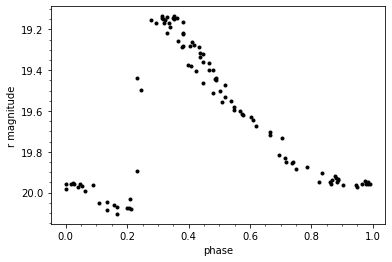

In [71]:
plt.plot(phase, mags, 'k.')
plt.gca().invert_yaxis()
plt.xlabel('phase')
plt.ylabel('r magnitude')
plt.minorticks_on()
plt.show()

Awesome - it looks like a typical RR Lyrae light curve (specifically, an _ab_-type RR Lyrae; see [this Wikipedia page](https://en.wikipedia.org/wiki/RR_Lyrae_variable) for more about these variable stars).

Note that by selecting the first measurement as our "zero-point" for the phase, we have chosen an arbitrary starting point. Ideally one might choose something more standard, like placing the peak of the light curve at phase = 0.


#### Summary 
You have now seen how to extract and work with time series data for a variable star. As you've seen, this is rather clunky with the DP0.1 dataset and tools. Extracting individual measurements from visits will be much easier in planned data products (e.g., in DP0.2), where the forced photometry on each visit will be tabulated in its own type of table.